In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, ifft, fftshift, ifftshift
from scipy.ndimage import fourier_shift
from scipy.interpolate import interp1d
from scipy import signal

# Signal Alignment

Theory
------

Two periodic correlated signals can be aligned by apply two search algorithms:
 
 1. Align to the correct rcycle of the periodic signal.
 2. Align to the nearest sample between the two closest repetitions.
 
Notes:
------
- Since delay calculated here is always positive:
    - **The target signal $g$ must always *lag* the reference signal $f$ by < $t_{stop}$.**
- Signals with sub-periodic periodic behaviour have additional requirements:
    - **The target signal $g$ must always *lag* the reference signal $f$ by < T (where T < $t_{stop}$).**
    - **You must specify the period, by default T = $t_{stop}$.**

## Create the Reference Signal (f)

In [2]:
upsample = 100
Fs = 150.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector
t_upsampled = np.arange(0, 1, Ts/upsample)

ff = 6;   # frequency of the signal
T = t[-1]/ff

# let's generate a sine signal
f = np.sin(2*np.pi*ff*t) + 0.5*1j*np.cos(2*np.pi*ff*t)
# sig = np.sin(2 * np.pi * t)
# f = signal.square(2 * np.pi * 30 * t, duty=(sig + 1)/2) + 0.5*1j*signal.square(2 * np.pi * 15 * t, duty=(sig + 1)/2)
T, Ts

(0.16555555555555557, 0.006666666666666667)

## Create Delayed Reference Signal (g)

In [36]:
# shift the signal in the frequency domain
delay = 55
g = fft(f)
g = fourier_shift(g, delay, n=-1, axis=-1)
g = ifft(g)

# or shift the signal in the time domain
g = signal.resample(f, f.size*upsample)
g = np.roll(g, int(delay*upsample))
g[0:int(delay*upsample)] = 0  # zero signal before the start to approximate single playback (non-periodic signals)
g = signal.resample(g, f.size)

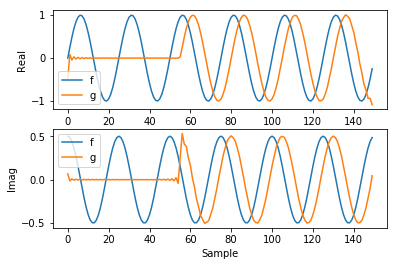

In [37]:
plt.figure(1)

plt.subplot(211)
plt.plot(f.real, label = 'f')
plt.plot(g.real, label = 'g')
plt.xlabel('Sample')
plt.ylabel('Real')
plt.legend()

plt.subplot(212)
plt.plot(f.imag, label = 'f')
plt.plot(g.imag, label = 'g')
plt.xlabel('Sample')
plt.ylabel('Imag')
plt.legend()

plt.show()

## Pad the signal with zeros to convert from circular convolution to linear convolution

In [38]:
size = f.size + g.size - 1
f_pad = np.concatenate((f, np.zeros(size)))
g_pad = np.concatenate((g, np.zeros(size)))

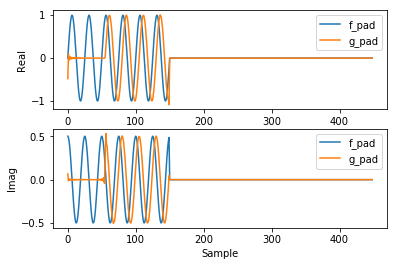

In [39]:
plt.figure(3)

plt.subplot(211)
plt.plot(f_pad.real, label = 'f_pad')
plt.plot(g_pad.real, label = 'g_pad')
plt.xlabel('Sample')
plt.ylabel('Real')
plt.legend()

plt.subplot(212)
plt.plot(f_pad.imag, label = 'f_pad')
plt.plot(g_pad.imag, label = 'g_pad')
plt.xlabel('Sample')
plt.ylabel('Imag')
plt.legend()

plt.show()

## Calculate Shift 

In [40]:
cycle_step = int(np.round(T / t[1]) / 2)
num_cycles = int(np.round(t.size/cycle_step)*2)
cycle_step

12

###  Fine Shift Align to the nearest sample.

In [41]:
fine_error = np.zeros(cycle_step, dtype=float)
for index in range(0, cycle_step):
    g_new = np.roll(g_pad, -index, axis=-1)
    fine_error[index] = np.sum(np.abs(f_pad*f_pad.conj() - g_new*g_new.conj()))
fine_offset = fine_error.argmin()
fine_offset

5

###  Coarse Shift Align to the correct half-cycle of the periodic signal.

In [42]:
coarse_error = np.zeros(num_cycles, dtype=float)
for index in range(0, num_cycles):
    g_new = np.roll(g_pad, -index*cycle_step - fine_offset, axis=-1)
    coarse_error[index] = np.sum(np.abs(f_pad*f_pad.conj() - g_new*g_new.conj()))
shift = coarse_error.argmin()*cycle_step + fine_offset
shift

5

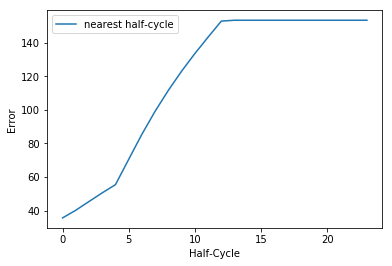

In [43]:
plt.figure(4)

plt.subplot(111)
plt.plot(coarse_error, label = 'nearest half-cycle')
plt.xlabel('Half-Cycle')
plt.ylabel('Error')
plt.legend()

plt.show()

## Apply Shift

In [44]:
g_new = fft(g)
g_new = fourier_shift(g_new, -fine_offset, n=-1, axis=-1)
g_new = ifft(g_new)

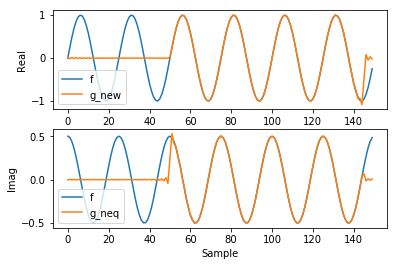

In [45]:
plt.figure(1)

plt.subplot(211)
plt.plot(f.real, label = 'f')
plt.plot(g_new.real, label = 'g_new')
plt.xlabel('Sample')
plt.ylabel('Real')
plt.legend()

plt.subplot(212)
plt.plot(f.imag, label = 'f')
plt.plot(g_new.imag, label = 'g_neq')
plt.xlabel('Sample')
plt.ylabel('Imag')
plt.legend()

plt.show()